# CH02.1. **Training Utility - Scheduler**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 1000
USE_CHECKPOINT_YN = 'N'
MODEL_PTH = '../../model/bostonRegEarlyStopping.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
# import torchinfo

#(2) Set up options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Set up device
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `describe_df()` function
def describe_df(df:pd.DataFrame) -> pd.DataFrame :
    output = pd.DataFrame(data={
        'dataType'     : df.dtypes,
        'nullCount'    : df.isnull().sum(),
        'nonNullCount' : (df.shape[0]-df.isnull().sum()),
        'uniqueCount'  : df.nunique()
    })
    return output

#(2) Define `compute_rmse()` function
def compute_rmse(model:torch.nn.Module, loader:torch.utils.data.DataLoader) -> int :
    model.eval()
    with torch.no_grad() : 
        square_sum = 0
        instance_num = 0
        for inputs, targets in loader :
            preds = model(x=inputs)
            square_sum += torch.sum(
                input=(preds-targets.to(device=preds.device))**2
            ).item()
            instance_num += len(targets)
    model.train()
    output = np.sqrt(square_sum/instance_num)
    return output

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `MyTensorDataset` class
class MyTensorDataset(torch.utils.data.Dataset) :
    def __init__(self, df:pd.DataFrame, pred_label_nm:'str', data_type:torch.dtype=torch.float32) :
        self.feature = torch.tensor(data=df.drop(labels=pred_label_nm, axis=1).values, dtype=data_type)
        self.label = torch.tensor(data=df.loc[:, pred_label_nm].values, dtype=data_type).reshape(shape=(-1, 1))
        self.len = self.label.shape[0]
    def __getitem__(self, index) :
        return self.feature[index], self.label[index]
    def __len__(self) :
        return self.len

#(2) Define `MyRegressionModel` class
class MyRegressionModel(torch.nn.Module) :
    def __init__(self, input_size:int, hidden_dims:list, device:torch.device) :
        super().__init__()
        self.device = device
        dims = [input_size] + hidden_dims
        for i in range(len(hidden_dims)):
            self.add_module(
                name=f'fc_block_{i}',
                module=torch.nn.Sequential(
                    torch.nn.Linear(in_features=dims[i], out_features=dims[i+1]),
                    torch.nn.BatchNorm1d(num_features=dims[i+1]),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(p=0.2)
                )
            )
        self.add_module(
            name=f'fc_block_{i+1}', 
            module=torch.nn.Sequential(
                torch.nn.Linear(in_features=dims[-1], out_features=1)
            )
        )
        self.to(device=device)
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        x = x.to(device=self.device)
        for block in self._modules.values():
            x = block(x)
        return x
    
#(3) Define `EarlyStopping` class
class EarlyStopping :
    def __init__(self, patience:int) :
        self.patience = patience
        self.best_val_cost = float('inf')
        self.counter = 0
        self.stop_yn = False
    def check(self, val_cost:float) :
        if val_cost < self.best_val_cost :
            self.best_val_cost = val_cost
            self.counter = 0
        else :
            self.counter += 1
            if self.counter >= self.patience :
                self.stop_yn = True

<b></b>

## 01. **데이터셋 로드 및 EDA**

#### 01.1. **데이터셋 로드**

In [5]:
boston_raw = pd.read_csv(filepath_or_buffer='../../data/boston.csv', index_col=[0])

#### 01.2. **EDA**

In [6]:
#(1) Display `boston_raw`
# boston_raw.head(n=10)

In [7]:
#(2) Describe `boston_raw`
# describe_df(df=boston_raw)

In [8]:
#(3) Check the statistics of `boston_raw`
# boston_raw.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()

In [9]:
#(4) Check `feature_dim` (input size)
feature_dim = boston_raw.drop(labels='Price', axis=1).shape[1]

#(5) Print `feature_dim`
# feature_dim

<b></b>

## 02. **데이터셋 전처리**

#### 02.1. **학습 및 검증 데이터셋 분리**

In [10]:
boston_train, boston_test = sklearn.model_selection.train_test_split(boston_raw, train_size=0.7, random_state=SEED_NUM)
boston_train, boston_val = sklearn.model_selection.train_test_split(boston_raw, train_size=0.9, random_state=SEED_NUM)

#### 02.2. **텐서 변환**

In [11]:
boston_train = MyTensorDataset(df=boston_train, pred_label_nm='Price', data_type=torch.float32)
boston_val = MyTensorDataset(df=boston_val, pred_label_nm='Price', data_type=torch.float32)
boston_test = MyTensorDataset(df=boston_test, pred_label_nm='Price', data_type=torch.float32)

#### 02.3. **데이터로더 변환**

In [12]:
boston_train_loader = torch.utils.data.DataLoader(dataset=boston_train, batch_size=BATCH_SIZE, shuffle=True)
boston_val_loader = torch.utils.data.DataLoader(dataset=boston_val, batch_size=BATCH_SIZE, shuffle=True)
boston_test_loader = torch.utils.data.DataLoader(dataset=boston_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **하이퍼 파라미터 정의**

In [13]:
hidden_dims = [128, 64, 32]

#### 03.2. **모델 정의**

In [14]:
#(1) Define `model`
model = MyRegressionModel(input_size=feature_dim, hidden_dims=hidden_dims, device=device).to(dtype=torch.float32)

#(3) Check `model`'s parameter number
# torchinfo.summary(
#     model=model, 
#     input_size=[BATCH_SIZE, feature_dim],
#     device=device
# )

In [15]:
#(3) Define loss function
criterion = torch.nn.MSELoss()

#(4) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-7)

#(5) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#(6) Define Earlystopping
early_stopping = EarlyStopping(patience=250)

#### 03.3. **모델 체크포인트 로드**

In [16]:
init_epoch = 0 
train_cost_hist = []
best_train_cost = float('inf')
val_cost_hist = []
best_val_cost = float('inf')
if USE_CHECKPOINT_YN == 'Y' :
    try :
        checkpoint = torch.load(f=MODEL_PTH, map_location=device)
        model.load_state_dict(state_dict=checkpoint['model'])
        optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
        init_epoch = checkpoint['best_epoch']
        train_cost_hist = checkpoint['train_cost_hist']
        best_train_cost = train_cost_hist[-1]
        val_cost_hist = checkpoint['validation_cost_hist']
        early_stopping.best_val_cost = val_cost_hist[-1]
    except Exception :
        pass
print(f'>> Last Epoch={init_epoch}, Last Train Loss={best_train_cost}, Last Validation Loss={early_stopping.best_val_cost}')

>> Last Epoch=0, Last Train Loss=inf, Last Validation Loss=inf


#### 03.4. **모델 학습**

In [17]:
best_epoch = init_epoch
train_batch_len = len(boston_train_loader)
val_batch_len = len(boston_val_loader)
progress_bar = tqdm.trange(init_epoch+1, EPOCH_NUM+1)
for epoch in progress_bar : 
    # ---- Train ---- # 
    train_cost = 0.0
    model.train()
    for train_inputs, train_targets in boston_train_loader :
        optimizer.zero_grad() 
        preds = model(x=train_inputs)
        train_loss = criterion(input=preds, target=train_targets.to(device=device))
        train_loss.backward()
        optimizer.step()
        train_cost += train_loss.item()
    train_cost = train_cost / train_batch_len
    train_cost_hist.append(train_cost)
    # ----- Validation ----- #
    model.eval()
    val_cost = 0.0
    with torch.no_grad() :
        for val_input, val_targets in boston_val_loader :
            preds_val = model(x=val_input)
            val_loss = criterion(input=preds_val, target=val_targets.to(device=device))
            val_cost += val_loss.item()
    val_cost = val_cost / val_batch_len
    val_cost_hist.append(val_cost)
    early_stopping.check(val_cost=val_cost)
    if early_stopping.stop_yn == True :
        print(f">> Early stopping triggered.")
        break
    elif early_stopping.best_val_cost < best_val_cost : 
        best_epoch = epoch
        best_train_cost = train_cost
        best_val_cost = val_cost
        torch.save(
            obj={
                'model'                : model.state_dict(),
                'optimizer'            : optimizer.state_dict(),
                'best_epoch'           : epoch,
                'train_cost_hist'      : train_cost_hist,
                'validation_cost_hist' : val_cost_hist
            }, 
            f=MODEL_PTH
        )
    # ---- ___________ ---- #
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={
        'last_epoch'           : epoch, 
        'last_train_cost'      : train_cost, 
        'last_validation_cost' : val_cost,
        'best_epoch'           : best_epoch,
        'best_train_cost'      : best_train_cost,
        'best_validation_cost' : best_val_cost
    })

 34%|███▍      | 338/1000 [00:58<01:53,  5.82it/s, last_epoch=338, last_train_cost=0.00743, last_validation_cost=0.0213, best_epoch=89, best_train_cost=0.0116, best_validation_cost=0.00919]

>> Early stopping triggered.


<b></b>

## 04. **모델 평가**

#### 04.1. **최적 성능 모델 로드**

In [18]:
checkpoint = torch.load(f=MODEL_PTH, map_location=device)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Best Epoch : {np.argmin(a=checkpoint["train_cost_hist"])+1}, Best Train Loss : {np.min(a=checkpoint["train_cost_hist"])}')
print(f'>> Best Epoch : {np.argmin(a=checkpoint["validation_cost_hist"])+1}, Best Validation Loss : {np.min(a=checkpoint["validation_cost_hist"])}')

>> Best Epoch : 85, Best Train Loss : 0.01029412355273962
>> Best Epoch : 89, Best Validation Loss : 0.009192712837830186


#### 04.2. **과소 적합 확인**

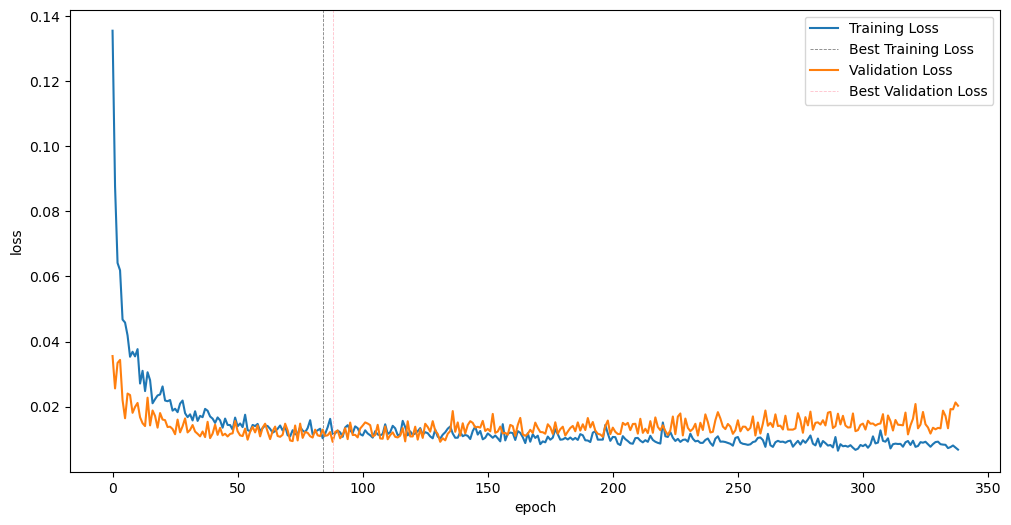

In [19]:
#(1) Plot training loss
plt.figure(figsize=(12, 6))
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(train_cost_hist, label='Training Loss')
plt.axvline(x=np.argmin(a=checkpoint["train_cost_hist"]), color='grey', linestyle='--', linewidth=0.6, label=f'Best Training Loss')
plt.plot(val_cost_hist, label='Validation Loss')
plt.axvline(x=np.argmin(a=checkpoint["validation_cost_hist"]), color='pink', linestyle='--', linewidth=0.6, label=f'Best Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [20]:
#(2) Check RMSE
rmse_train = compute_rmse(model=model, loader=boston_train_loader)
print(f'>> Train RMSE: {rmse_train}')

>> Train RMSE: 0.08227313155481995


#### 04.3. **일반화 성능 평가**

In [21]:
rmse_test = compute_rmse(model=model, loader=boston_test_loader)
print(f'>> Test RMSE : {rmse_test}')

>> Test RMSE : 0.08347011771463955
